Tutorial: Computing Normal Stresses and Dynamic Topography in G-ADOPT
====================================================================

One of the most commonly studied geodynamic observables is **dynamic topography**
surface or lithospheric deflection caused by vertical stresses from mantle flow. This means that
areas of Earth's surface or core-mantle boundary are pushed
up or pulled down due to underlying mantle convection.
This "dynamic" topography is transient, and differs from isostatic topography (like
mountain building from crustal thickening).

This tutorial demonstrates how to compute **normal stresses acting on a boundary**
and subsequent dynamic topography using **G-ADOPT**.

Specifically, we will compute the vertical stress $\sigma_{yy}$ on the boundaries of a
2-D square domain, and use them to calculate dynamic topography. We examine a time-independent
simulation with free-slip boundary conditions, where the internal structure is loaded
from a checkpoint file from our tutorials' base case. Note that given the lack of time-dependence,
we do not solve an energy equation, and deal with the Stokes system only.

Theory Refresher
----------------
Dynamic topography arises from the internal stress field deforming a surface.
Consider the top boundary of an annular domain located at radius $r_{max}$.
Under equilibrium, the vertical (radial) stress acting on this boundary is $\sigma_{rr}$.
Due to internal forces, the surface deforms by an amount $\delta h$, which can be calculated as follows:

$$\delta h = \sigma_{rr} / (\delta \rho g)$$

Where:
  - $\sigma_{rr}$ is the normal stress at the boundary,
  - $\delta \rho$ is the density difference between mantle and the overlying medium (air or water),
  - $g \approx 9.8 m/s^2$ is gravitational acceleration.



Implementation in G-ADOPT
-------------------------

The first step is to import the gadopt module, which
provides access to Firedrake and associated functionality.
We also import pyvista and matplotlib, which are used for plotting purposes.

In [1]:
from gadopt import *

We also import pyvista for doing file visualisations for this notebook.

In [2]:
import pyvista as pv

We next load the mesh from a checkpoint file and initialise the temperature field
noting that in this tutorial the temperature field is used only through the fixed buoyancy term on the
RHS of the Stokes equation. Cartesian flags and boundary IDs are collected in a way that is
consistent with our previous tutorials.

In [3]:
# Load the mesh and temperature field from the base case
input_file = "../base_case/Final_State.h5"
with CheckpointFile(input_file, mode="r") as f:
    mesh = f.load_mesh("firedrake_default")
    T = f.load_function(mesh, "Temperature")

mesh.cartesian = True
boundaries = get_boundary_ids(mesh)

We next set up function spaces, and specify functions to hold our solutions,
as with our previous tutorials.

In [4]:
V = VectorFunctionSpace(mesh, "CG", 2)
W = FunctionSpace(mesh, "CG", 1)
Z = MixedFunctionSpace([V, W])

z = Function(Z)
u, p = split(z)  # Returns symbolic UFL expression for u and p
z.subfunctions[0].rename("Velocity")
z.subfunctions[1].rename("Pressure")

We can now visualise the mesh.

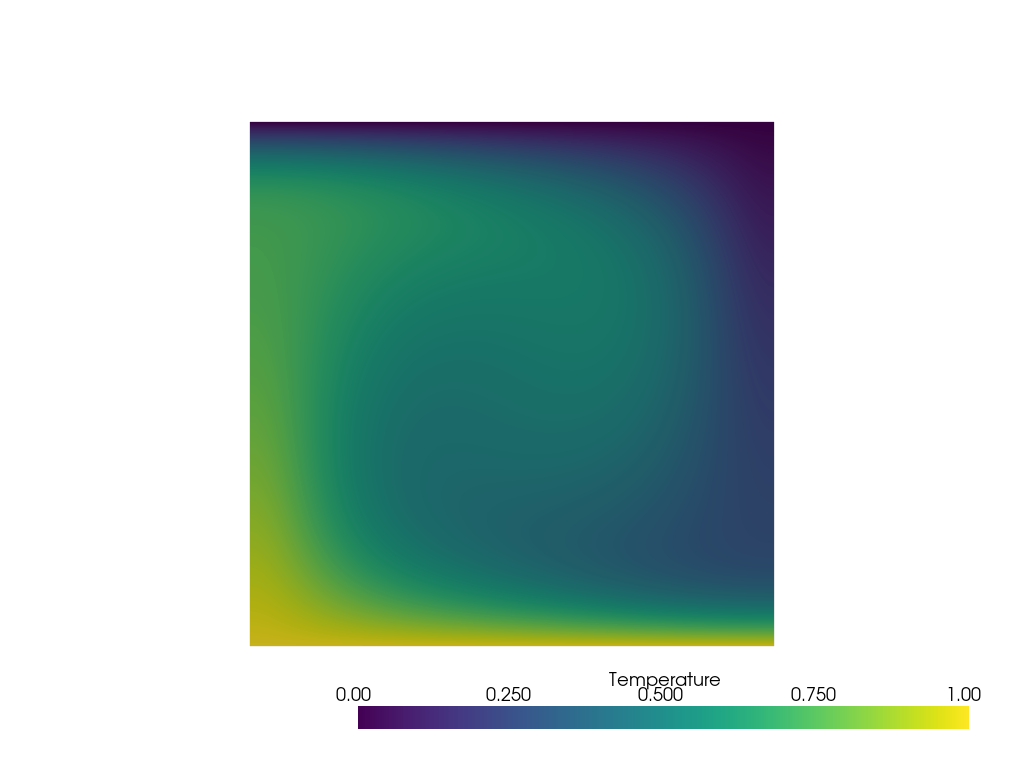

In [5]:
VTKFile("temperature.pvd").write(T)
temp_data = pv.read("temperature/temperature_0.vtu")
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(temp_data)
plotter.camera_position = "xy"
plotter.show(jupyter_backend="static", interactive=False)

We next specify the constants and physical approximation for this problem.
Note that this case is time independent and hence, when compared to most of our previous
tutorials, no timestepping options are specified.

In [6]:
Ra = Constant(1e4)
approximation = BoussinesqApproximation(Ra)

As noted previously, with a free-slip boundary condition on both boundaries, one can add an arbitrary constant to the pressure solution (i.e. this case incorporates a pressure nullspace). These lead to null-modes (eigenvectors) for the linear system, resulting in a singular matrix.
In preconditioned Krylov methods these null-modes must be subtracted from the approximate solution at every iteration. We do that below,
setting up a nullspace object as we did in the previous tutorial.

In [7]:
Z_nullspace = create_stokes_nullspace(Z, closed=True, rotational=False)

Boundary conditions are next specified. For velocity, we specify free‐slip conditions on both boundaries. As noted in our
2-D cylindrical tutorial, we incorporate these <b>weakly</b> through the <i>Nitsche</i> approximation. Given we do not solve
an energy equation for this time independent case, no boundary conditions are required for temperature.

In [8]:
stokes_bcs = {
    boundaries.bottom: {'uy': 0},
    boundaries.top: {'uy': 0},
    boundaries.left: {'ux': 0},
    boundaries.right: {'ux': 0},
}

We can now setup and solve the variational problem for the Stokes equations,
passing in the approximation, nullspace information configured above.

In [9]:
stokes_solver = StokesSolver(
    z,
    T,
    approximation,
    bcs=stokes_bcs,
    nullspace=Z_nullspace,
    transpose_nullspace=Z_nullspace,
    solver_parameters="direct",
)

stokes_solver.solve()

At this point, we have a global solution for velocity and pressure. Let's visualise them:

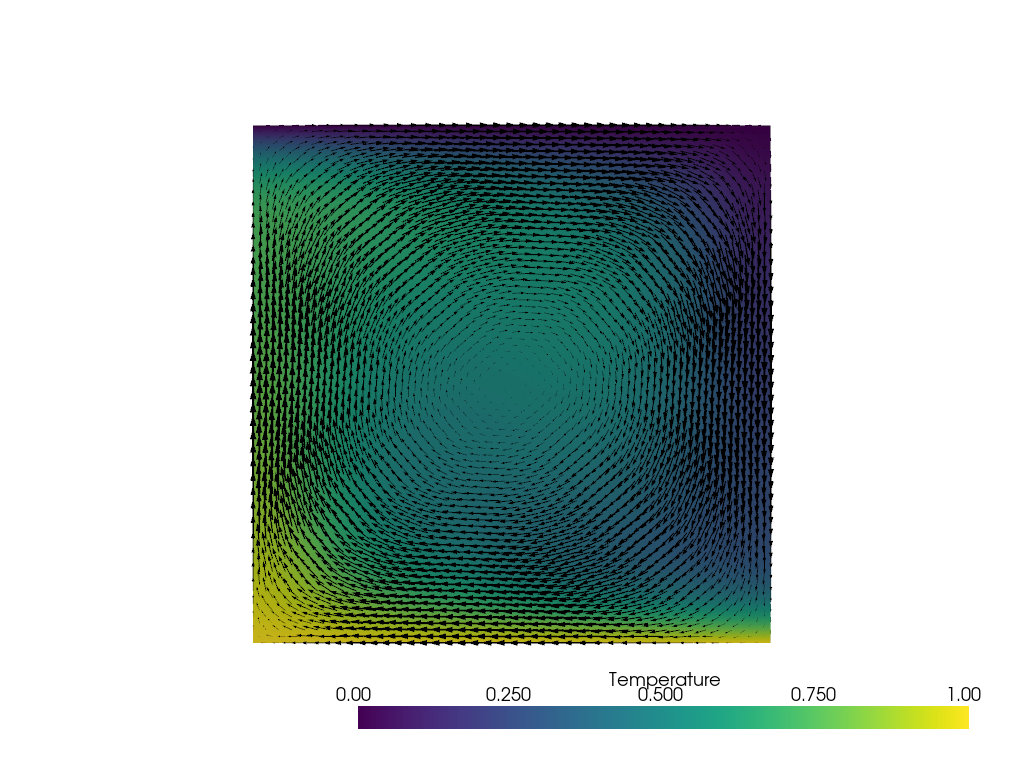

In [10]:
VTKFile("velocity.pvd").write(z.subfunctions[0])
u_data = pv.read("velocity/velocity_0.vtu").glyph(factor=1e-3, orient="Velocity", tolerance=1e-2)
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(temp_data)
plotter.add_mesh(u_data, color="black")
plotter.camera_position = "xy"
plotter.show(jupyter_backend="static", interactive=False)

Next, the global solutions is used to compute normal stresses at both
top and bottom boundaries, via the `force_on_boundary` method.

In [11]:
ns_top = stokes_solver.force_on_boundary(boundaries.top)
ns_bottom = stokes_solver.force_on_boundary(boundaries.bottom)

    Linear BoundaryNormalStressSolver_4_ solve converged due to CONVERGED_RTOL iterations 6


    Linear BoundaryNormalStressSolver_3_ solve converged due to CONVERGED_RTOL iterations 6


With these normal stresses, we can now calculate the dynamic topography at both the surface and bottom boundaries (CMB) using:

$$\delta_{h} = \frac{\sigma_{yy}}{(\Delta \rho * g)}$$

where:
  - $\sigma_{yy}$ is the normal stress at the boundary,
  - $\Delta \rho$ is the density difference across the boundary,
  - $g$ is gravitational acceleration.

Since the Stokes system in G-ADOPT is non-dimensionalized, we use non-dimensional values for density and gravity at the top boundary (both set to Constant(1.0)).
For the CMB, we assume the outer core is 2.5 times denser than the mantle (\Delta \rho_CMB = Constant(2.5)), and set gravity to Constant(1.0).
To further normalise, you can multiply the non-dimensional normal stress by the mantle depth,  $ L = 2.89 \times 10^6 $  m.
Below, we also log the average velocity of the domain, and dynamic topography at the top and bottom boundaries for our checks.

In [12]:
parameter_log = ParameterLog('params.log', mesh)
parameter_log.log_str("u_rms dyna_topo_avg_top dyna_topo_avg_bottom")
gd = GeodynamicalDiagnostics(z, T, boundaries.top, boundaries.bottom)

# Create Function objects for dynamic topography
dimensionalisation_factor = Constant(3e-5 * 4e3 * 3e6) / Ra  # i.e., (Thermal Expansivity) x (Background Earth's Mantle Density) x (Thickness of mantle) / (Ra number)
dynamic_topography_top = Function(W, name="Dynamic_Topography_Top")
dynamic_topography_bottom = Function(W, name="Dynamic_Topography_Bottom")

# Compute dynamic topography values
delta_rho_top = Constant(1.0)  # i.e., \Delta \rho_top = 1.0 \times \rho_mantle
g_top = Constant(1.0)
dynamic_topography_top.interpolate(ns_top / (delta_rho_top * g_top) * dimensionalisation_factor)
dyna_topo_avg_top = sqrt(
    assemble(dynamic_topography_top**2 * ds(subdomain_id=boundaries.top))
)

delta_rho_cmb = Constant(-2.5)  # i.e., \Delta \rho_CMB = (\rho_mantle - \rho_outer_core) / \rho_mantle
g_cmb = Constant(1.0)
dynamic_topography_bottom.assign(ns_bottom / (delta_rho_cmb * g_cmb) * dimensionalisation_factor)
dyna_topo_avg_bottom = sqrt(
    assemble(dynamic_topography_bottom**2 * ds(subdomain_id=boundaries.bottom))
)

parameter_log.log_str(f"{gd.u_rms()} {dyna_topo_avg_top} {dyna_topo_avg_bottom}")
parameter_log.close()


Now it's time to visualise all the calculations in one figure.

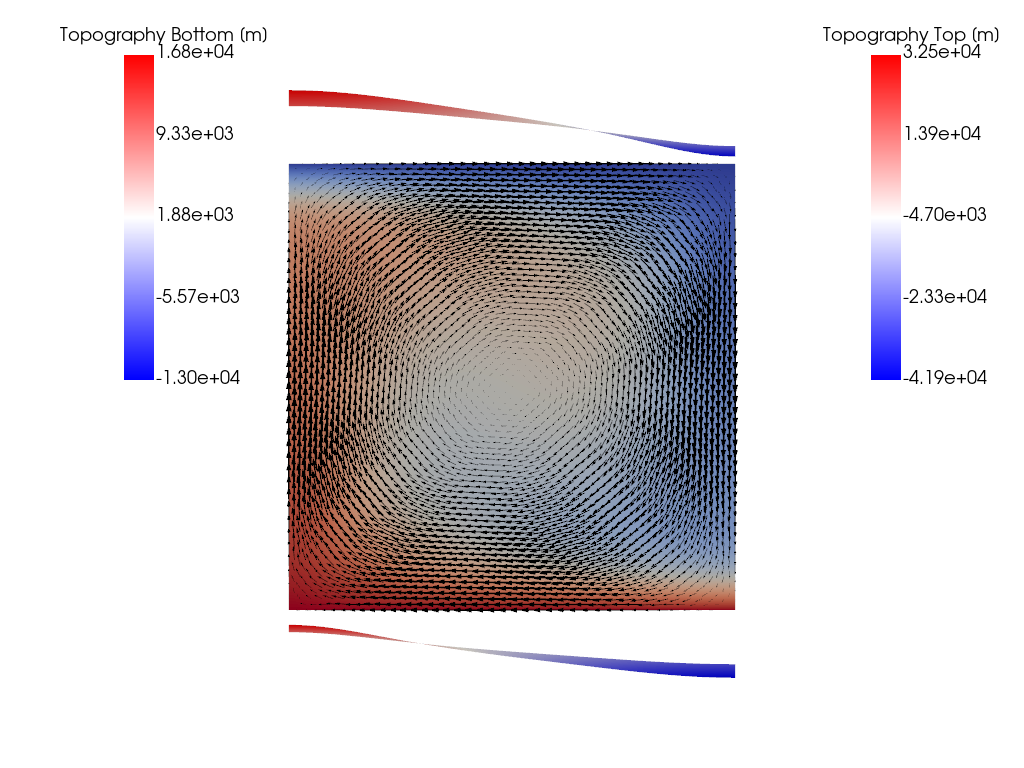

In [13]:
# Let's write out dynamic topography fields to disk to visualise them using pyvista
VTKFile("dt.pvd").write(dynamic_topography_top, dynamic_topography_bottom)
# Loading dynamic topography calculations
dt_data = pv.read("./dt/dt_0.vtu")
# We scale the mesh for dynamic topography fields so we can see temperature and velocity fields
# Here, we scale top boundary layer by 1.3 and bottom boundary layer by 0.7
import numpy as np
transform_top = pv.Transform().translate([0, 0.1, 0], multiply_mode="pre")
transform_bottom = pv.Transform().translate([0, -.1, 0], multiply_mode="pre")

# Now a bit of complicated stuff to extract nice topography surfaces
# Extract the top part of the domain just for top boundary condition
outer = dt_data.clip(normal=[0, 1, 0], origin=[0, 0.99, 0], invert=False, inplace=False).transform(transform_top, inplace=False)
warped_outer = outer.warp_by_scalar("Dynamic_Topography_Top", factor=2e-6, normal=[0, 1, 0], inplace=False)
# Extract the bottom part of the domain just for bottom boundary condition
inner = dt_data.clip(normal=[0, 1, 0], origin=[0, 0.01, 0], invert=True, inplace=False).transform(transform_bottom, inplace=False)
warped_inner = inner.warp_by_scalar("Dynamic_Topography_Bottom", factor=4e-6, normal=[0, +1, 0], inplace=False)

# Plot those nice surfaces
plotter = pv.Plotter(notebook=True)
t_plot = plotter.add_mesh(temp_data, scalars="Temperature", cmap="coolwarm", clim=[0, 1], show_scalar_bar=False)
plotter.add_mesh(u_data, color="black")
dt_plot_top = plotter.add_mesh(warped_outer, scalars="Dynamic_Topography_Top", cmap="bwr", show_scalar_bar=False)
dt_plot_bot = plotter.add_mesh(warped_inner, scalars="Dynamic_Topography_Bottom", cmap="bwr", show_scalar_bar=False)
plotter.camera_position = "xy"
_ = plotter.add_scalar_bar( 'Topography Top [m]', mapper=dt_plot_top.mapper, position_x=0.85, position_y=0.5, vertical=True)
_ = plotter.add_scalar_bar( 'Topography Bottom [m]', mapper=dt_plot_bot.mapper, position_x=0.12, position_y=0.5, vertical=True)
plotter.show(jupyter_backend="static", interactive=False)

This tutorial has demonstrated how to:
- Load fields and meshes from checkpoint files.
- Solve the Stokes system using G-ADOPT.
- Compute normal stresses on top and bottom boundaries.
- Estimate dynamic topography from those normal stresses.
- Save and visualise the results.